In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Walmart_Colab Notebooks/dataset"

calendar.csv		    sales_train_validation.csv	sell_prices.csv
sales_train_evaluation.csv  sample_submission.csv


# **EDA**


### **Major dataframe below:**

sales_df

calendar_df

price_df

sales_long

**sales_train_validation.csv** is training dataset

**sales_train_evaluation.csv** right now I am not sure about......😅😅😅

In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# introduce filepath
file_path = "/content/drive/My Drive/Walmart_Colab Notebooks/dataset"

# Read the CSV file
sales_df = pd.read_csv(file_path + "/sales_train_validation.csv")

# Display the first few rows
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


## Number of unique items per category

In [ ]:
unique_items_per_cat = sales_df.groupby('cat_id')['item_id'].nunique().reset_index(name='unique_item_count')

# Sort the results
unique_items_per_cat = unique_items_per_cat.sort_values(by='unique_item_count', ascending=False)

# Display the result
unique_items_per_cat


,cat_id,unique_item_count
0,FOODS,1437
2,HOUSEHOLD,1047
1,HOBBIES,565


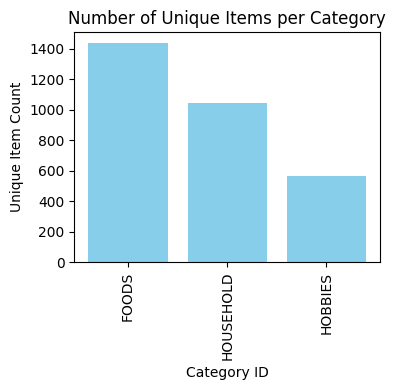

In [ ]:
# Plot the number of unique items per category
plt.figure(figsize=(4, 4))
plt.bar(unique_items_per_cat['cat_id'], unique_items_per_cat['unique_item_count'], color='skyblue')
plt.title('Number of Unique Items per Category')
plt.xlabel('Category ID')
plt.ylabel('Unique Item Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Among 3049 unique products, around 47%(1437) of products falls under FOODS category , 34%(1047) falls under HOUSEHOLD category and leftover 18.5%(565) products are of HOBBIES category.So ,in given data there are lot of products related to food items

## Total Daily Sales (CA + TX + WI) Over Time

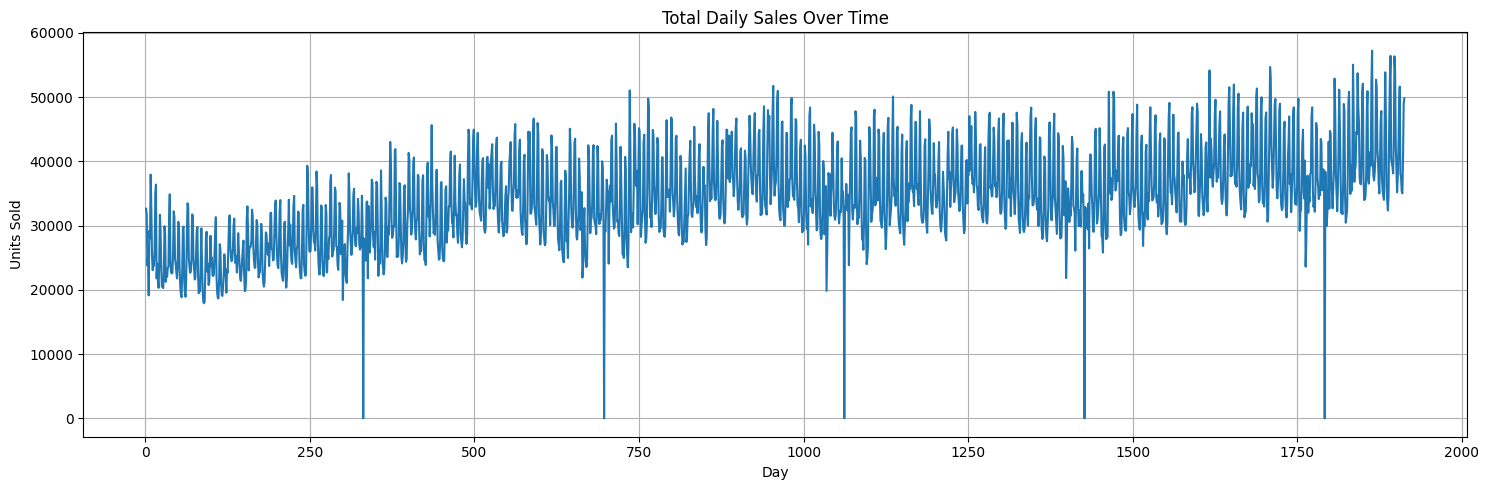

In [ ]:
# Step 1: Select only the 'd_' columns (daily sales)
daily_sales = sales_df.loc[:, sales_df.columns.str.startswith('d_')]

# Step 2: Sum across all rows to get total sales per day
total_daily_sales = daily_sales.sum(axis=0)

# Step 3 (Optional): Rename 'd_1' to 'd_1913' into actual dates
# For now, just convert them to a numeric index
total_daily_sales.index = range(1, len(total_daily_sales) + 1)

# Step 4: Plot the time series
plt.figure(figsize=(15, 5))
plt.plot(total_daily_sales.index, total_daily_sales.values)
plt.title('Total Daily Sales Over Time')
plt.xlabel('Day')
plt.ylabel('Units Sold')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Check if there is close day(total_daily_sales = 0)
total_daily_sales[total_daily_sales == 0]

,0


**Patterns:**

1.First thing observed is the pattern ,for each year it slightly having same pattern.

2.Year by year sales increment in sales in slow but compare to 2011 , year 2016 as increase of sales up to range of 60k

3.At end of each year the sales are dropping drastically.


## Total Daily Sales (by state) Over Time

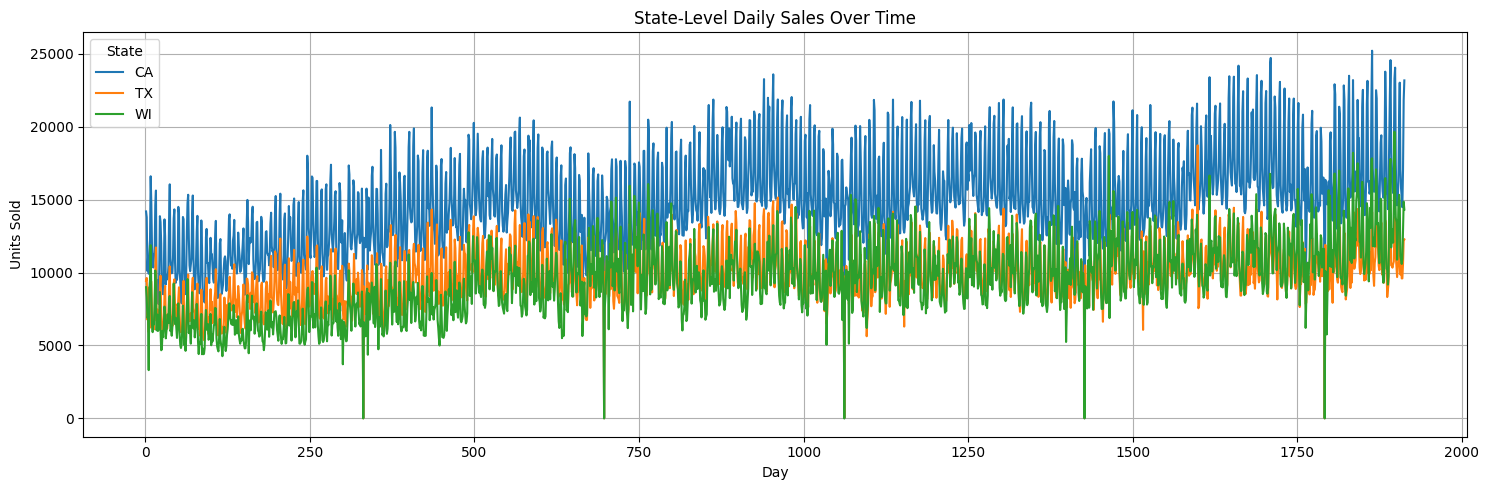

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Filter daily sales columns
daily_sales = sales_df.loc[:, sales_df.columns.str.startswith('d_')]

# Step 2: Group by 'state_id' and sum daily sales within each state
state_daily_sales = sales_df.groupby('state_id')[daily_sales.columns].sum()

# Step 3: Convert column names (d_1, d_2, ...) to integer days
state_daily_sales.columns = range(1, len(state_daily_sales.columns) + 1)

# Step 4: Plot the time series for each state
plt.figure(figsize=(15, 5))
for state in state_daily_sales.index:
    plt.plot(state_daily_sales.columns, state_daily_sales.loc[state], label=state)

plt.title('State-Level Daily Sales Over Time')
plt.xlabel('Day')
plt.ylabel('Units Sold')
plt.legend(title='State')
plt.grid(True)
plt.tight_layout()
plt.show()

**Patterns:**

1.More sales are occurring in California state than other two states.

2.TX and WI has almost same sales pattern ,so in these states sales are happening in almost same range.

3.In California sales are increasing slightly but in other two states sales are almost in same medium in each year and at end of each year sales are dropping.

## Monthly Sales in Each State

In [ ]:
# Step 1: Load sales and calendar data
calendar_df = pd.read_csv(file_path + '/calendar.csv')

In [ ]:
# Step 2: Filter daily sales columns
daily_cols = [col for col in sales_df.columns if col.startswith('d_')]
sales_data = sales_df[['state_id'] + daily_cols]

# Step 3: Melt sales data into long format (one row per state-day)
sales_melted = sales_data.melt(id_vars='state_id', var_name='d', value_name='sales')

# Step 4: Merge with calendar to get actual dates
sales_with_date = sales_melted.merge(calendar_df[['d', 'date']], on='d', how='left')
sales_with_date['date'] = pd.to_datetime(sales_with_date['date'])

# Step 5: Extract year and month
sales_with_date['year_month'] = sales_with_date['date'].dt.to_period('M')

# Step 6: Group by state and month
monthly_sales_by_state = sales_with_date.groupby(['state_id', 'year_month'])['sales'].sum().reset_index()

# Step 7: (Optional) Pivot for better readability
monthly_pivot = monthly_sales_by_state.pivot(index='year_month', columns='state_id', values='sales')

# Display result
print(monthly_pivot.tail())


<ipython-input-5-df3deb28c4ec>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales_with_date['date'] = pd.to_datetime(sales_with_date['date'])


state_id        CA      TX      WI
year_month                        
2015-12     479557  305981  340698
2016-01     525392  321790  368104
2016-02     505704  328110  379113
2016-03     538930  343674  393142
2016-04     443417  272545  330726


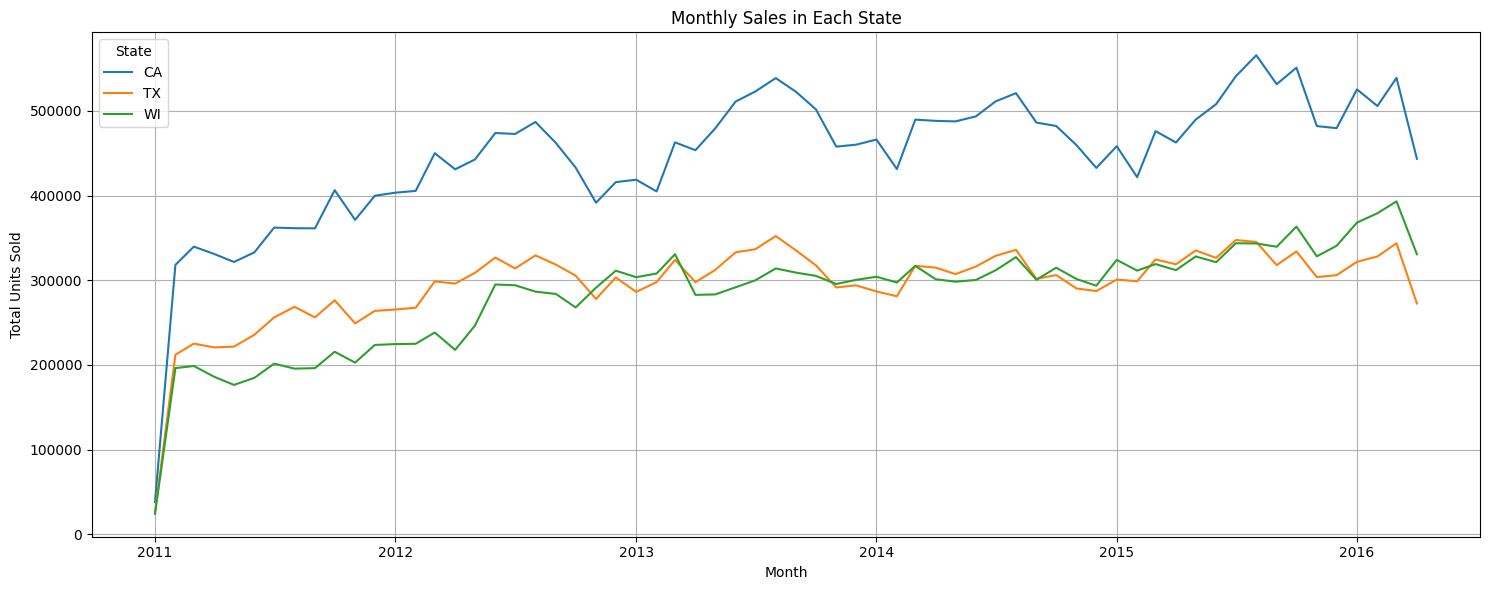

In [ ]:
plt.figure(figsize=(15, 6))
for state in monthly_pivot.columns:
    plt.plot(monthly_pivot.index.to_timestamp(), monthly_pivot[state], label=state)

plt.title('Monthly Sales in Each State')
plt.xlabel('Month')
plt.ylabel('Total Units Sold')
plt.legend(title='State')
plt.grid(True)
plt.tight_layout()
plt.show()


**Patterns:**

1.CA state has more sales than two states.

2.In California,up to 2014 sales as increased but slightly dropped in between 2014 -2015 span and again after 2015 sales tends to increasing ,TX and WI has almost same sales rate from 2013 year.

3.From 2013 TX,WI has some constant sales up to mid 2015 and then it increased slightly.

## Total sales by state

Preparation: calculate sales of each day

In [ ]:
# Filter columns that start with 'd_'
daily_sales_cols = [col for col in sales_df.columns if col.startswith('d_')]

# Add a new column sales_df['total_sales']
# Sum across all days per row, then group by state
sales_df['total_sales'] = sales_df[daily_sales_cols].sum(axis=1)


In [ ]:
# calculate sales of each state
state_total_sales = sales_df.groupby('state_id')['total_sales'].sum().reset_index()
print(state_total_sales)

  state_id  total_sales
0       CA     28675547
1       TX     18899006
2       WI     18120856


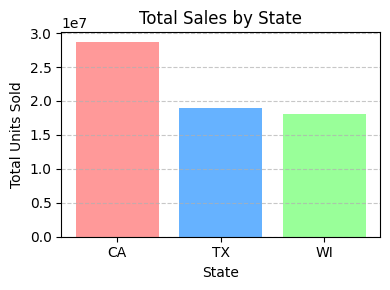

In [ ]:
states = state_total_sales['state_id']
totals = state_total_sales['total_sales']

# Plot
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFD700', '#FFA07A', '#DA70D6', '#87CEFA']

# If you have more states than colors, you can repeat or use a colormap
colors = colors[:len(states)]  # trim if needed

# Plot
plt.figure(figsize=(4,3))
plt.bar(states, totals, color=colors)

plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Units Sold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Patterns:**

1. CA state has high number of sales i.e nearly 30 millions whereas other two sates TX,WI has almost same percent of sales.

2. CA state records 43percent of sales and also approx 10 percent greater sales than other two states.


## Total sales by category in each state

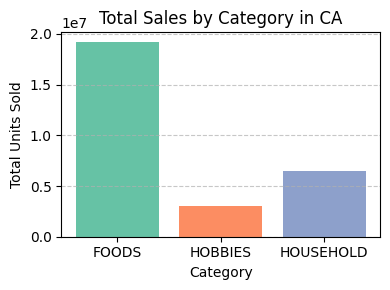

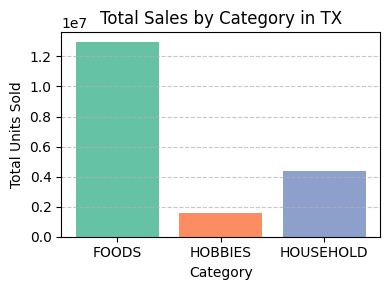

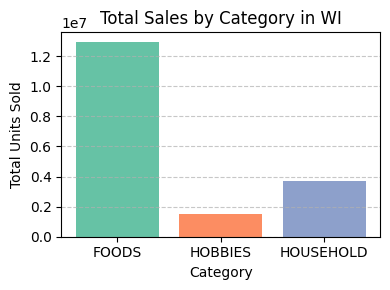

In [ ]:
# Sum across all days per row
sales_df['total_sales'] = sales_df[daily_cols].sum(axis=1)

# Group by state and category
grouped = sales_df.groupby(['state_id', 'cat_id'])['total_sales'].sum().reset_index()

# Get unique states
states = grouped['state_id'].unique()

# Plot one chart per state
for state in states:
    df_state = grouped[grouped['state_id'] == state]

    plt.figure(figsize=(4,3))
    plt.bar(df_state['cat_id'], df_state['total_sales'], color=['#66c2a5', '#fc8d62', '#8da0cb'])
    plt.title(f'Total Sales by Category in {state}')
    plt.xlabel('Category')
    plt.ylabel('Total Units Sold')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

**Patterns:**

1.In all states ,higher sales on food category and very less sales on households and each state almost falling same distribution of sales for each categories.

## Total sales by dept_id

In [ ]:
# Group by 'dept_id' and sum the sales
dept_total_sales = sales_df.groupby('dept_id')['total_sales'].sum().reset_index()

# Get the unique mapping from 'dept_id' to 'cat_id' (ensure one-to-one mapping)
dept_cat_map = sales_df[['dept_id', 'cat_id']].drop_duplicates()

# Merge dept_total_sales with the dept_cat_map on 'dept_id'
dept_total_sales = dept_total_sales.merge(dept_cat_map, on='dept_id', how='left')

dept_total_sales

,dept_id,total_sales,cat_id
0,FOODS_1,5088041,FOODS
1,FOODS_2,7629822,FOODS
2,FOODS_3,32372076,FOODS
3,HOBBIES_1,5596460,HOBBIES
4,HOBBIES_2,528340,HOBBIES
5,HOUSEHOLD_1,11500526,HOUSEHOLD
6,HOUSEHOLD_2,2980144,HOUSEHOLD


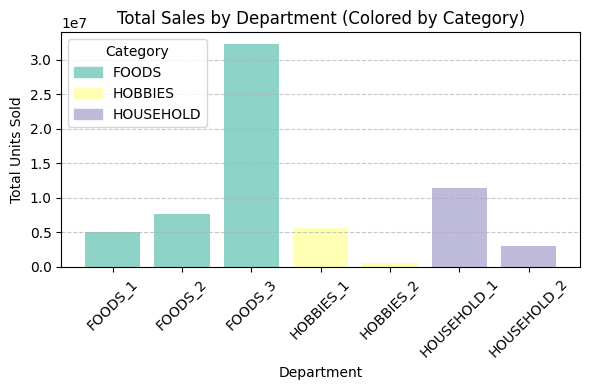

In [ ]:
# Define a color palette (seaborn color palette)
palette = sns.color_palette("Set3", n_colors=len(dept_total_sales['cat_id'].unique()))

# Map the category to colors
color_map = {cat: palette[i] for i, cat in enumerate(dept_total_sales['cat_id'].unique())}
colors = dept_total_sales['cat_id'].map(color_map)

# Plot with colors based on 'cat_id'
plt.figure(figsize=(6,4))
plt.bar(dept_total_sales['dept_id'], dept_total_sales['total_sales'], color=colors)

# Title and labels
plt.title('Total Sales by Department (Colored by Category)')
plt.xlabel('Department')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optional: Add legend for 'cat_id'
handles = [plt.Rectangle((0,0),1,1,color=color_map[cat]) for cat in color_map]
plt.legend(handles, color_map.keys(), title='Category', loc='upper left')

plt.tight_layout()
plt.show()

**Patterns:**

1.Foods_3 shows significantly high consumption among food category, and it has the highest unit_sold among all categories


## Total sale per store

In [ ]:
# Group by store_id
store_total_sales = sales_df.groupby('store_id')['total_sales'].sum().reset_index()

# Get state_id per store — pick the first state_id for each store
store_states = sales_df[['store_id', 'state_id']].drop_duplicates()

# Merge store-level sales with their states
store_total_sales = store_total_sales.merge(store_states, on='store_id', how='left')
store_total_sales

,store_id,total_sales,state_id
0,CA_1,7698216,CA
1,CA_2,5685475,CA
2,CA_3,11188180,CA
3,CA_4,4103676,CA
4,TX_1,5595292,TX
5,TX_2,7214384,TX
6,TX_3,6089330,TX
7,WI_1,5149062,WI
8,WI_2,6544012,WI
9,WI_3,6427782,WI


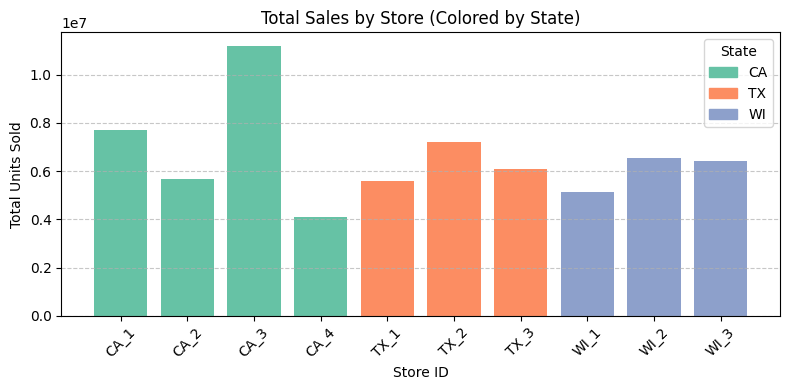

In [ ]:

# Define color map
state_colors = {
    'CA': '#66c2a5',
    'TX': '#fc8d62',
    'WI': '#8da0cb'
}

# Step 7: Map state_id to colors
colors = store_total_sales['state_id'].map(state_colors)

# Step 8: Plot
plt.figure(figsize=(8, 4))
plt.bar(store_total_sales['store_id'], store_total_sales['total_sales'], color=colors)

plt.title('Total Sales by Store (Colored by State)')
plt.xlabel('Store ID')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend manually
handles = [plt.Rectangle((0,0),1,1,color=color) for color in state_colors.values()]
labels = state_colors.keys()
plt.legend(handles, labels, title='State', loc='upper right')

plt.tight_layout()
plt.show()

**Patterns:**

1.CA_3 store which has the highest total sales from 2011-2016, almost 17%

2.CA state stores had different sales percentage for each store, with CA_3 showing highest total sales and CA_2 showing lowest sale


## Number of products in each department

In [ ]:
products_per_dept = sales_df.groupby('dept_id')['item_id'].nunique().reset_index()
products_per_dept.columns = ['dept_id', 'num_products']

products_per_dept


,dept_id,num_products
0,FOODS_1,216
1,FOODS_2,398
2,FOODS_3,823
3,HOBBIES_1,416
4,HOBBIES_2,149
5,HOUSEHOLD_1,532
6,HOUSEHOLD_2,515


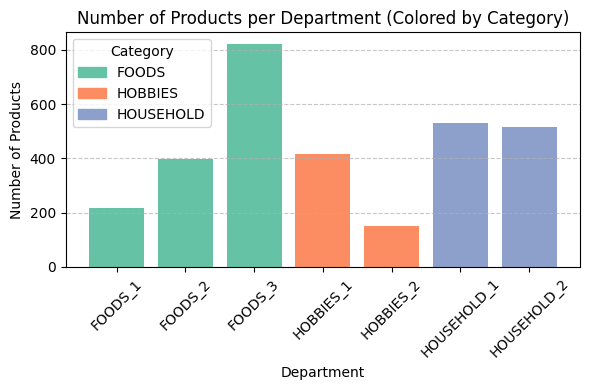

In [ ]:
dept_cat_map = sales_df[['dept_id', 'cat_id']].drop_duplicates()
products_per_dept = products_per_dept.merge(dept_cat_map, on='dept_id', how='left')

# Set color palette by category
unique_cats = products_per_dept['cat_id'].unique()
palette = dict(zip(unique_cats, sns.color_palette('Set2', len(unique_cats))))

plt.figure(figsize=(6, 4))
bars = plt.bar(
    products_per_dept['dept_id'],
    products_per_dept['num_products'],
    color=[palette[cat] for cat in products_per_dept['cat_id']]
)

# Add legend manually
handles = [plt.Rectangle((0,0),1,1, color=palette[cat]) for cat in unique_cats]
plt.legend(handles, unique_cats, title="Category")

plt.title('Number of Products per Department (Colored by Category)')
plt.xlabel('Department')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Patterns:**

1. In food department, dept food3 has more number of products whereas dept food2,dept food1 has very less no of food products.

2. Household's two departments has almost 50% of products in each dept.

3. Hobbies products has least number of categories and dept1 has more products.

## Total sales of each department

In [ ]:
# Sum total sales across all days per row
daily_cols = [col for col in sales_df.columns if col.startswith('d_')]
sales_df['total_sales'] = sales_df[daily_cols].sum(axis=1)

# Group by dept_id and sum total sales
dept_total_sales = sales_df.groupby('dept_id')['total_sales'].sum().reset_index()

# Get dept to cat mapping
dept_cat_map = sales_df[['dept_id', 'cat_id']].drop_duplicates()

# Merge to include cat_id
dept_total_sales = dept_total_sales.merge(dept_cat_map, on='dept_id', how='left')


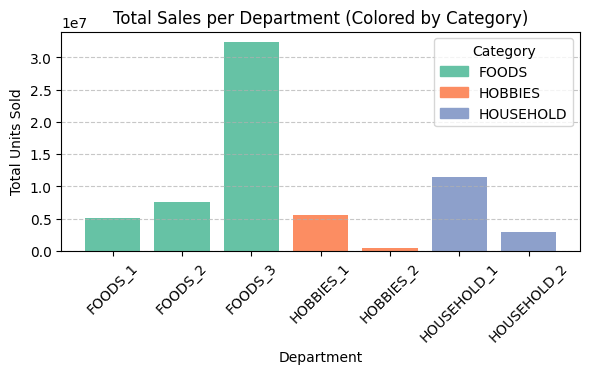

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Unique categories and color palette
unique_cats = dept_total_sales['cat_id'].unique()
palette = dict(zip(unique_cats, sns.color_palette('Set2', len(unique_cats))))

plt.figure(figsize=(6,4))
bars = plt.bar(
    dept_total_sales['dept_id'],
    dept_total_sales['total_sales'],
    color=[palette[cat] for cat in dept_total_sales['cat_id']]
)

# Legend
handles = [plt.Rectangle((0,0),1,1, color=palette[cat]) for cat in unique_cats]
plt.legend(handles, unique_cats, title='Category')

plt.title('Total Sales per Department (Colored by Category)')
plt.xlabel('Department')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Patterns:**

1.Nearly 50 per of sales are from food_3 dept.

2.Sales of household items is higher than sales of food deptartments.

## The most popular items (item_id)


In [ ]:
# 1. Identify daily sales columns
daily_cols = [col for col in sales_df.columns if col.startswith('d_')]

# 2. Sum total sales for each item across all stores
sales_df['total_sales'] = sales_df[daily_cols].sum(axis=1)

# 3. Group by item_id to get total units sold per item
item_total_sales = sales_df.groupby('item_id')['total_sales'].sum().reset_index()

# 4. Sort to find the most popular items
top_items = item_total_sales.sort_values(by='total_sales', ascending=False)
top_items.head(10)

,item_id,total_sales
702,FOODS_3_090,1002529
1198,FOODS_3_586,920242
864,FOODS_3_252,565299
1167,FOODS_3_555,491287
1325,FOODS_3_714,396172
1199,FOODS_3_587,396119
1306,FOODS_3_694,390001
838,FOODS_3_226,363082
814,FOODS_3_202,295689
1334,FOODS_3_723,284333


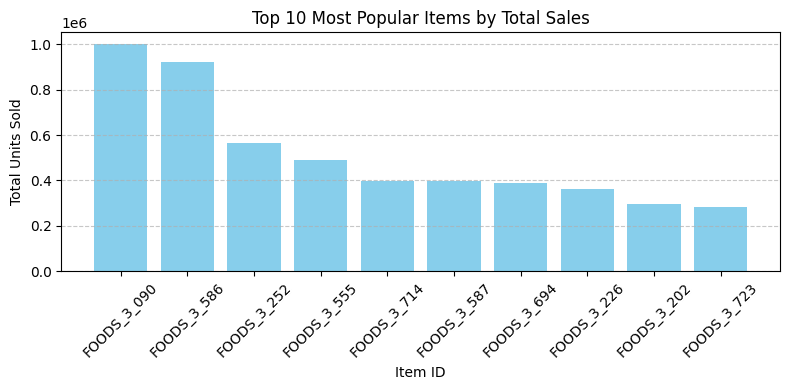

In [ ]:
top_10 = top_items.head(10)

plt.figure(figsize=(8,4))
plt.bar(top_10['item_id'], top_10['total_sales'], color='skyblue')

plt.title('Top 10 Most Popular Items by Total Sales')
plt.xlabel('Item ID')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Patterns:**

1. In the top10 items, all of them come from Foods_3 department, and FOODS_3_090 and FOODS_3_586 are much higher than others(> 0.9 * 10^6).

--------------------------------

--------------------------------

## Average price per item of each store

In [ ]:
# Read sell_prices.csv
price_df = pd.read_csv(file_path + "/sell_prices.csv")

# Display the first few rows
price_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
item_store_price = price_df.groupby(['store_id', 'item_id'])['sell_price'].mean().reset_index()
item_store_price.columns = ['store_id', 'item_id', 'avg_sell_price']

item_store_price.head()

,store_id,item_id,avg_sell_price
0,CA_1,FOODS_1_001,2.169362
1,CA_1,FOODS_1_002,8.937447
2,CA_1,FOODS_1_003,2.976809
3,CA_1,FOODS_1_004,1.851378
4,CA_1,FOODS_1_005,3.334468


## Average sales from Monday to Sunday

In [ ]:
# Step 1: Identify daily sales columns
daily_cols = [col for col in sales_df.columns if col.startswith('d_')]

# Step 2: Melt sales_df into long format
sales_long = sales_df.melt(
    id_vars=['item_id'],
    value_vars=daily_cols,
    var_name='d',
    value_name='units_sold'
)

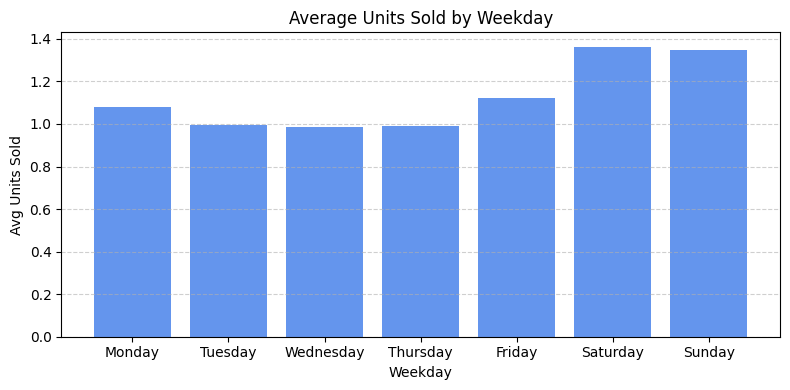

In [ ]:
# Step 3: Merge with calendar_df to get weekdays
sales_long = sales_long.merge(calendar_df[['d', 'weekday']], on='d', how='left')

# Step 4: Group by weekday and calculate average sales
avg_sales_by_weekday = sales_long.groupby('weekday')['units_sold'].mean().reset_index()

# Step 5: Order weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_sales_by_weekday['weekday'] = pd.Categorical(
    avg_sales_by_weekday['weekday'],
    categories=weekday_order,
    ordered=True
)
avg_sales_by_weekday = avg_sales_by_weekday.sort_values('weekday')

# Step 6: Plot
plt.figure(figsize=(8, 4))
plt.bar(
    avg_sales_by_weekday['weekday'],
    avg_sales_by_weekday['units_sold'],
    color='cornflowerblue'
)

plt.title('Average Units Sold by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Avg Units Sold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Patterns:**

1. Sunday, Saturday and Friday show high average sales.

## Average sales by event

In [ ]:
# Step 1: Identify daily sales columns
daily_cols = [col for col in sales_df.columns if col.startswith('d_')]

# Step 2: Merge with calendar_df to get event_type_1
sales_long = sales_long.merge(calendar_df[['d', 'event_type_1']], on='d', how='left')

# Step 3: Replace NaN with 'Non-Event'
sales_long['event_type_1'] = sales_long['event_type_1'].fillna('Non-Event')

In [ ]:
# Group by event_type_1 and calculate average sales
avg_sales_by_event = sales_long.groupby('event_type_1')['units_sold'].mean().reset_index()

# Sort (optional: custom order)
event_order = ['Non-Event', 'Sporting', 'Cultural', 'National', 'Religious']
avg_sales_by_event['event_type_1'] = pd.Categorical(
    avg_sales_by_event['event_type_1'],
    categories=event_order,
    ordered=True
)
avg_sales_by_event = avg_sales_by_event.sort_values('event_type_1')


In [ ]:
# display
avg_sales_by_event

,event_type_1,units_sold
2,Non-Event,1.131165
4,Sporting,1.174026
0,Cultural,1.122819
1,National,0.966170
3,Religious,1.107271


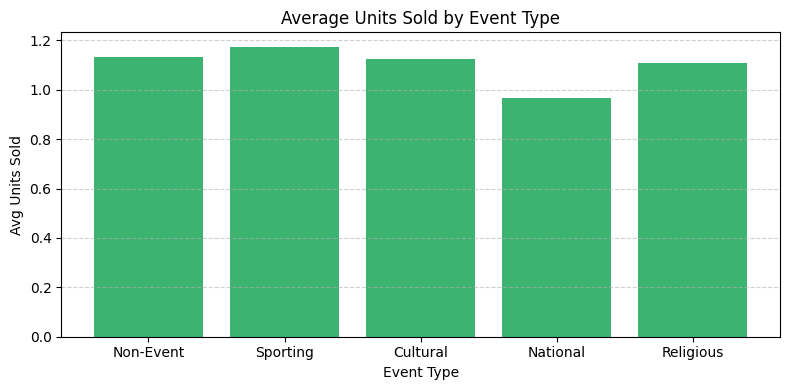

In [ ]:
# Plot
plt.figure(figsize=(8, 4))
plt.bar(
    avg_sales_by_event['event_type_1'],
    avg_sales_by_event['units_sold'],
    color='mediumseagreen'
)

plt.title('Average Units Sold by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Avg Units Sold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Patterns:**

1. Sporting event shows the highest average units sold while National event shows the lowest average unites sold.